# Target-embedding autoencoders

In [21]:
import importlib
import numpy as np
import pandas as pd
import os
from pathlib import Path
from tqdm import tqdm

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader

from data.skl_synthetic import make_skl_dataset, load_skl_data
# import models.linear
from models.linear import LinearAE, LinearMLP, MiniLinearMLP, LinearTEA
from plotting import plot_losses, plot_predicted_vs_actual

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

### Load data, set model paramaters 

In [3]:
home = Path.home()
path_for_data = home/"teas-data/sklearn/"
if not os.path.exists(path_for_data):
    make_skl_dataset()
if os.path.exists(path_for_data):
    X_train, X_valid, X_test, Y_train, Y_valid, Y_test = map(FloatTensor, load_skl_data(path_for_data))

In [4]:
batch_size = 128
train_ds = TensorDataset(X_train, Y_train)
valid_ds = TensorDataset(X_valid, Y_valid)
test_ds = TensorDataset(X_test, Y_test)
train_dl = DataLoader(train_ds, batch_size)
valid_dl = DataLoader(valid_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [5]:
# these give us some shape values for later
X, Y = next(iter(train_ds))
input_dim = X.shape[0]
hidden_dim = 128
output_dim = Y.shape[0]

### First, train a simple linear autoencoder *for Y*

In [6]:
lae_model = LinearAE(output_dim, hidden_dim)

In [7]:
# train the linear AE
epochs = 20
lr = 5e-4
opt = optim.Adam(lae_model.parameters(), lr)
mse = nn.MSELoss()
train_loss, valid_loss = [], []

In [8]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([lae_model.update_batch(Y, opt, mse) for _, Y in train_dl])
    this_valid_loss = np.mean([lae_model.update_batch(Y, opt, mse, train=False) for _, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


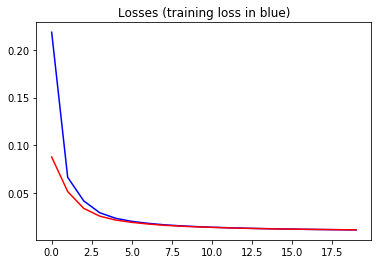

In [9]:
plot_losses(epochs, train_loss, valid_loss)

### Final validation loss (predict Y from Y)

In [10]:
print("Final valid loss: {}".format(valid_loss[-1]))

Final valid loss: 0.011798328021541238


### Visualise predicted vs. actual

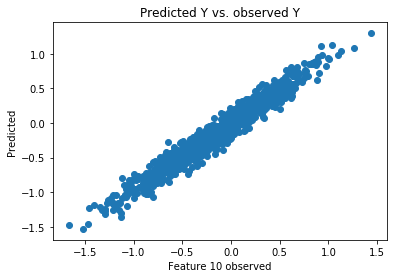

In [11]:
# pick a row, generate predictions
idx = 10
X, Y = valid_ds[idx]
# Y_hat, X_tilde = lfea_model(X)
Y_tilde = lae_model(Y)
plot_predicted_vs_actual(Y, Y_tilde, idx, title = "Predicted Y vs. observed Y")

Now we train a mini MLP to map X to Z

In [12]:
# importlib.reload(models.linear)

In [13]:
mini_mlp_model = MiniLinearMLP(input_dim = 100, output_dim = 128)

In [14]:
epochs = 5
lr = 1e-0
opt = optim.Adam(mini_mlp_model.parameters(), lr)
mse = nn.MSELoss()
train_loss, valid_loss = [], []
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([mini_mlp_model.update_batch(X, lae_model.Z_from_X(Y), opt, mse) for X, Y in train_dl])
    this_valid_loss = np.mean([mini_mlp_model.update_batch(X, lae_model.Z_from_X(Y), opt, mse, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 5/5 [00:00<00:00,  6.09it/s]


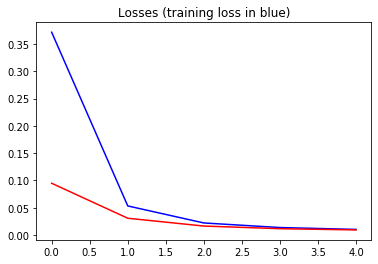

In [15]:
plot_losses(epochs, train_loss, valid_loss)

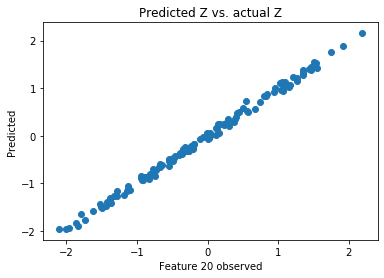

In [16]:
# pick a row, generate predictions
idx = 20
X, Y = valid_ds[idx]
Z = lae_model.Z_from_X(Y)
# Y_hat, X_tilde = lfea_model(X)
Z_hat = mini_mlp_model(X)
plot_predicted_vs_actual(Z, Z_hat, idx, title = "Predicted Z vs. actual Z")

In [17]:
def compute_Y_hat(X): return(lae_model.X_from_Z(mini_mlp_model(X)))

In [18]:
# valid losses
valid_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in valid_ds:
    Y_hat = compute_Y_hat(X)
    valid_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

Final test MSE loss on prediction task: 0.015723178163170815


It worked great!!

### Now use these weights in a TEA

In [22]:
ltea_model = LinearTEA(input_dim, hidden_dim, output_dim)
ltea_model

LinearTEA(
  (input_X): Linear(in_features=100, out_features=128, bias=True)
  (input_Y): Linear(in_features=1000, out_features=128, bias=True)
  (predict_Y): Linear(in_features=128, out_features=1000, bias=True)
)

### Copy the weights and biases from the trained AE and MLP

In [23]:
ltea_model.input_X.load_state_dict(mini_mlp_model.input_output.state_dict(), strict=True),\
ltea_model.input_Y.load_state_dict(lae_model.input.state_dict(), strict=True),\
ltea_model.predict_Y.load_state_dict(lae_model.output.state_dict(), strict=True)

(IncompatibleKeys(missing_keys=[], unexpected_keys=[]),
 IncompatibleKeys(missing_keys=[], unexpected_keys=[]),
 IncompatibleKeys(missing_keys=[], unexpected_keys=[]))

Our LinearTEA should now predict, given the weights we have fed in...

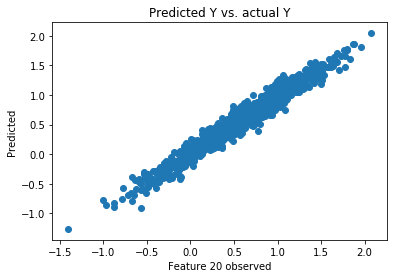

In [24]:
# pick a row, generate predictions
idx = 20
X, Y = valid_ds[idx]
Y_hat = ltea_model.predict_Y_from_X(X)
plot_predicted_vs_actual(Y, Y_hat, idx, title = "Predicted Y vs. actual Y")

In [30]:
class JointLoss(nn.Module):
    """
    Parameters
    ----------
    lambda_ : float
        Weighting in the joint joss. 
        Lower lambda_ favours lower Y from Y reconstruction loss.
    """
    def __init__(self, lambda_=0.5):
        super().__init__()
        self.X = X
        self.Y = Y
        self.lambda_ = lambda_
        
    def forward(self, Y, Y_hat, Z, Z_hat):
        mse = nn.MSELoss()
        return ( ((1 - self.lambda_) * mse(Y_hat, Y)) + (self.lambda_ * mse(Z_hat, Z)) )

If the joint loss is working, then with $\lambda = 1.0$ we should get a standard MSE

In [26]:
compute_Y_hat(X)

tensor([ 7.3902e-01,  6.1395e-01,  1.1156e-01,  5.8197e-01,  6.2706e-01,
         2.4502e-01,  5.3607e-01,  6.9235e-01,  9.1045e-02,  1.1421e+00,
         5.0413e-01,  9.8023e-01,  1.2354e-01, -3.6659e-01,  1.1461e+00,
         6.0373e-01,  5.3884e-01,  8.7803e-01,  7.0398e-01,  8.8142e-01,
         6.4546e-01,  7.0705e-01,  2.4585e-01,  7.9755e-01,  2.4555e-01,
         9.7118e-01,  6.0865e-01,  3.5722e-01,  4.1828e-01,  5.3554e-01,
        -1.9744e-01,  5.1717e-01,  5.8596e-01,  3.9193e-01,  9.0760e-01,
         1.4112e+00,  7.0643e-01, -4.3853e-02,  1.2369e+00, -1.2578e-01,
         1.1979e+00,  6.5126e-01,  1.7574e+00,  5.8996e-01,  7.3901e-01,
         6.9215e-01, -1.4907e-01,  3.9831e-01,  1.4713e+00,  7.8341e-01,
        -1.4612e-01,  5.0932e-01,  6.9301e-01,  7.2470e-01,  2.5910e-01,
        -5.4810e-01,  1.2662e+00,  1.3277e+00,  7.7289e-01,  1.8279e-01,
         2.1357e-01,  1.3144e-01,  3.5483e-01,  1.4415e+00,  9.9290e-01,
         2.0073e-01,  1.2996e+00,  1.0280e+00,  1.3

In [31]:
joint_loss = JointLoss(lambda_=1.0)

In [32]:
assert( ltea_model.update_batch(X, Y, opt, joint_loss, train=False) == mse(compute_Y_hat(X), Y) )

AssertionError: 

In [33]:
# valid losses
pred_error = []
joint_loss = JointLoss(lambda_ = 1.0)
for X, Y in valid_ds:
    pred_error.append(ltea_model.update_batch(X, Y, opt, joint_loss, train=False))
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

Final test MSE loss on prediction task: 0.009213451512157918


In [34]:
np.mean(pred_error)

0.009213451512157918

In [36]:
# train the linear TEA
epochs = 30
lr = 5e-4
opt = optim.Adam(ltea_model.parameters(), lr)
criterion = JointLoss(lambda_= .25)
train_loss, valid_loss = [], []

In [37]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion) for X, Y in train_dl])
    this_valid_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 30/30 [00:08<00:00,  3.32it/s]


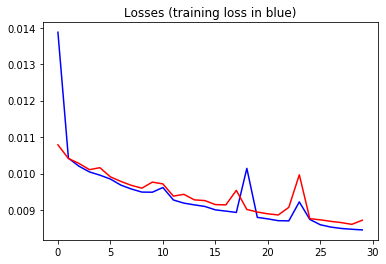

In [38]:
plot_losses(epochs, train_loss, valid_loss)

### Final validation loss on predicting Y from X

In [39]:
# validation losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in valid_ds:
    Y_hat = ltea_model.predict_Y_from_X(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final validation MSE loss on prediction task: {}".format(np.mean(pred_error)))

Final validation MSE loss on prediction task: 0.013314152136445045


Results for different values of lambda:

| Lambda   | Final validation loss |
| :------- | :------------------   |
| 0.00     | 0.5848469138145447    |
| 0.25     | 0.20141418278217316   |
| 0.50     | 0.1873609572649002    |
| 0.75     |     ||

The best performing model(s) favour Y_hat loss.

### Test loss 

In [ ]:
# test losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in test_ds:
    Y_hat, _ = lfea_model(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

In [ ]:
gc.collect()